In [1]:
import cython
import numpy as np
import TidalPy
import CyRK
print('Cython', cython.__version__)
print('TidalPy', TidalPy.__version__)
print('CyRK', CyRK.__version__)

Cython 3.0.2
TidalPy 0.5.0a5.dev27
CyRK 0.8.4a0.dev2


In [7]:
import numpy as np

from TidalPy.rheology.models import MaxwellRheology
frequency    = 0.01
radius       = 0.1
density      = 7000.
bulk_modulus = 100.0e9

shear         = 5.0e9
viscosity     = 1.0e20
rheo_inst     = MaxwellRheology()
complex_shear = rheo_inst(frequency, shear, viscosity)

G_to_use = 6.6743e-11

from TidalPy.radial_solver.numerical.initial import find_initial_guess
from TidalPy.radial_solver.numerical.initial.driver import find_initial_conditions
from TidalPy.radial_solver.numerical.solutions import find_num_solutions

results = [
    (True, True, True, True, 2),
    (True, True, True, True, 3),
    (True, True, True, False, 2),
    (True, True, True, False, 3),
    (True, True, False, False, 2),
    (True, True, False, False, 3),
    (True, True, False, True, 2),
    (True, True, False, True, 3),
    (True, False, True, False, 2),
    (True, False, True, False, 3),
    (True, False, True, True, 2),
    (True, False, True, True, 3),
    (True, False, False, False, 2),
    (True, False, False, False, 3),
    (True, False, False, True, 2),
    (True, False, False, True, 3),
    (False, True, True, True, 2),
    (False, True, True, True, 3),
    (False, True, True, False, 2),
    (False, True, True, False, 3),
    (False, True, False, False, 2),
    (False, True, False, False, 3),
    (False, True, False, True, 2),
    (False, True, False, True, 3),
    (False, False, True, False, 2),
    (False, False, True, False, 3),
    (False, False, True, True, 2),
    (False, False, True, True, 3),
    (False, False, False, False, 2),
    (False, False, False, False, 3),
    (False, False, False, True, 2),
    (False, False, False, True, 3),
    ]

for is_solid, is_static, is_incompressible, use_kamata, degree_l in results:
    
    try:
        # Get new result
        num_sols = find_num_solutions(is_solid, is_static, is_incompressible)
        num_ys = num_sols * 2

        # Create array full of nans for the "output" array. If things worked okay then they should no longer be nan.
        initial_condition_array = np.nan * np.ones((num_sols, num_ys), dtype=np.complex128, order='C')

        find_initial_conditions(
            is_solid, is_static, is_incompressible, use_kamata,
            frequency, radius, density, bulk_modulus, complex_shear,
            degree_l, G_to_use, initial_condition_array
            )

        print(f'({is_solid}, {is_static}, {is_incompressible}, {use_kamata}, {degree_l}): np.asarray(\n', end='')
        print(f'    ' + f'{list(initial_condition_array.flatten())}\n    ),'.replace(', ', ',\n    '))
        
    except:
        print(f'# ({is_solid}, {is_static}, {is_incompressible}, {use_kamata}, {degree_l}): NotImplementedError()')


# (True, True, True, True, 2): NotImplementedError()
# (True, True, True, True, 3): NotImplementedError()
# (True, True, True, False, 2): NotImplementedError()
# (True, True, True, False, 3): NotImplementedError()
(True, True, False, False, 2): np.asarray(
    [(-0.0032974903825663095-3.963755911749528e-05j),
    (175176397.06620377-3963756.3583191438j),
    (-0.0015979632402011285-1.9818779586862884e-05j),
    (-119952714.22660895-1981878.5528268134j),
    (-89208.03780768627-0.0002595284163026111j),
    (-4460401.890384294-0.012976420582417617j),
    (0.001202948522094405-1.823371942697851e-05j),
    (-502589766.7579282-1823373.1159757504j),
    (0.0006874270038427265-9.11685965667499e-06j),
    (101552151.82972601-911685.4692695896j),
    (74922.32352197179+0.00018809984480102444j),
    (3746116.176098582+0.00940499234710177j),
    (0.2+0j),
    (20000000000+100j),
    (0.1+0j),
    (10000000000+50j),
    (3.9140139449328135e-08+0j),
    (7.828027889865629e-07+0j)]
    ),
(True, Tru

In [2]:
%load_ext cython

In [5]:
%%cython --annotate --force
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

cpdef double functel(double a):
    return a * a

Content of stdout:
_cython_magic_f71aafe9b925efa504b15ece244309d68a94a010.c
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_f71aafe9b925efa504b15ece244309d68a94a010.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_f71aafe9b925efa504b15ece244309d68a94a010.cp311-win_amd64.exp
Generating code
Finished generating code

In [138]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libc.math cimport NAN, INFINITY, \
    isfinite, isnan, copysign, sqrt, fabs, signbit, exp, cos, sin, log, log1p, ldexp, atan2, frexp, ceil
from libc.float cimport DBL_MAX, DBL_MIN, DBL_MANT_DIG


cdef int DBL_MANT_DIG_INT = <int>DBL_MANT_DIG

cdef long double SQRT2 = 1.414213562373095048801688724209698079  # sqrt 2
cdef long double LOGE2 = 0.693147180559945309417232121458176568  # log_e 2

# We risk spurious overflow for components >= DBL_MAX / (1 + sqrt(2)).
cdef double THRESH = DBL_MAX / (1.0 + SQRT2)
cdef double DBL_MAX_4 = DBL_MAX / 4.

# scaled_cexp precison constant
#if @precision@ == 1
# precision for float
cdef int SCALED_CEXP_K_F = 235
# precision for double
cdef int SCALED_CEXP_K_D = 1799
# precision for long double
cdef int SCALED_CEXP_K_LD = 19547

cdef double SCALED_K_LOGE2_D = SCALED_CEXP_K_D * LOGE2

cdef float SCALED_CEXP_LOWERF = 88.722839
cdef float SCALED_CEXP_UPPERF = 192.69492
cdef double SCALED_CEXP_LOWER = 710.47586007394386
cdef double SCALED_CEXP_UPPER = 1454.9159319953251
cdef long double SCALED_CEXP_LOWERL = 11357.216553474703895
cdef long double SCALED_CEXP_UPPERL = 22756.021937783004509



cdef double carg(double complex z) noexcept nogil:
    return atan2(z.imag, z.real)


cdef double hypot(double x, double y) noexcept nogil:

    cdef double yx
    cdef double temp

    if not isfinite(x) or not isfinite(y):
        return INFINITY

    if isnan(x) or isnan(y):
        return NAN

    x = fabs(x)
    y = fabs(y)
    if x < y:
        temp = x
        x    = y
        y    = temp

    if x == 0.:
        return 0.
    else:
        yx = y / x
        return x * sqrt(1. + yx * yx)


cdef double complex csqrt(double complex z) noexcept nogil:
    cdef double complex result
    cdef double a, b
    cdef double t
    cdef int scale

    a = z.real
    b = z.imag

    # Handle special cases.
    if b == 0.0:
        if a == 0.0:
            return 0.0 + 0.0j
        elif a > 0.0:
            return sqrt(a) + 0.0j

    if not isfinite(b):
        return INFINITY + 1.0j * b

    if isnan(a):
        # raise invalid if b is not a NaN
        t = (b - b) / (b - b)
        # Return NaN + NaN i
        return a + 1.0j * t

    if not isfinite(a):
        # csqrt(inf + NaN i)  = inf +  NaN i
        # csqrt(inf + y i)    = inf +  0 i
        # csqrt(-inf + NaN i) = NaN +- inf i
        # csqrt(-inf + y i)   = 0   +  inf i

        if signbit(a):
            return fabs(b - b) + 1.0j * copysign(a, b)
        else:
            return a + 1.0j * copysign(b - b, b)

    # The remaining special case (b is NaN) is handled just fine by the normal code path below.
    # Scale to avoid overflow.
    if fabs(a) >= THRESH or fabs(b) >= THRESH:
        a *= 0.25
        b *= 0.25
        scale = 1
    else:
        scale = 0

    # Algorithm 312, CACM vol 10, Oct 1967.
    if a >= 0.0:
        t = sqrt((a + hypot(a, b)) * 0.5)
        result = t + 1.0j * b / (2.0 * t)
    else:
        t = sqrt((-a + hypot(a, b)) * 0.5)
        result = fabs(b) / (2 * t) + 1.0j * copysign(t, b)

    # Rescale.
    if scale:
        return result.real * 2.0 + 1.0j * result.imag
    else:
        return result


cdef double complex scaled_cexp(double x, double y, int expt) noexcept nogil:

    cdef double mant, mantcos, mantsin
    cdef int ex, excos, exsin
    
    mant = frexp(exp(x - SCALED_K_LOGE2_D), &ex)
    mantcos = frexp(cos(y), &excos)
    mantsin = frexp(sin(y), &exsin)

    expt += ex + SCALED_CEXP_K_D
    return ldexp(mant * mantcos, expt + excos) + 1.0j * ldexp(mant * mantsin, expt + exsin)


cdef double complex cexp(double complex z) noexcept nogil:
    cdef double x, c, s
    cdef double complex ret
    
    cdef double z_real = z.real
    cdef double z_imag = z.imag

    if isfinite(z_real):
        if (z_real >= SCALED_CEXP_LOWER) and (z_real <= SCALED_CEXP_UPPER):
            ret = scaled_cexp(z_real, z_imag, 0)
        else:
            x = exp(z_real)
            c = cos(z_imag)
            s = sin(z_imag)

            if isfinite(z_imag):
                ret = (x * c) + 1.0j * (x * s)
            else:
                ret = NAN + 1.0j * copysign(NAN, z_imag)
    elif isnan(z_real):
        # z_real is nan
        if z_imag == 0:
            ret = z
        else:
            ret = z_real + 1.0j * copysign(NAN, z_imag)
    else:
        # z_real is +- inf
        if z_real > 0:
            if z_imag == 0:
                ret = z
            elif isfinite(z_imag):
                c = cos(z_imag)
                s = sin(z_imag)

                ret = (z_real * c) + 1.0j * (z_real * s)
            else:
                # x = +inf, y = +-inf | nan
                ret = z_real + 1.0j * NAN
        else:
            if isfinite(z_imag):
                x = exp(z_real)
                c = cos(z_imag)
                s = sin(z_imag)

                ret = (x * c) + 1.0j * (x * s)
            else:
                # x = -inf, y = nan | +i inf
                ret = 0.0 + 0.0j
    return ret


cdef double complex clog(double complex z) noexcept nogil:
    # algorithm from cpython, rev. d86f5686cef9
    # 
    # The usual formula for the real part is log(hypot(z.real, z.imag)).
    # There are four situations where this formula is potentially
    # problematic:
    # 
    # (1) the absolute value of z is subnormal.  Then hypot is subnormal,
    #  so has fewer than the usual number of bits of accuracy, hence may
    #  have large relative error.  This then gives a large absolute error
    #  in the log.  This can be solved by rescaling z by a suitable power
    #  of 2.
    # 
    # (2) the absolute value of z is greater than DBL_MAX (e.g. when both
    #  z.real and z.imag are within a factor of 1/sqrt(2) of DBL_MAX)
    #  Again, rescaling solves this.
    #  
    # (3) the absolute value of z is close to 1.  In this case it's
    #  difficult to achieve good accuracy, at least in part because a
    #  change of 1ulp in the real or imaginary part of z can result in a
    #  change of billions of ulps in the correctly rounded answer.
    #  
    # (4) z = 0.  The simplest thing to do here is to call the
    #  floating-point log with an argument of 0, and let its behaviour
    #  (returning -infinity, signaling a floating-point exception, setting
    #  errno, or whatever) determine that of c_log.  So the usual formula
    #  is fine here.

    cdef double z_real = z.real
    cdef double z_imag = z.imag
    cdef double z_real_abs = fabs(z_real)
    cdef double z_imag_abs = fabs(z_imag)

    cdef double h, a_max, a_min
    cdef double r_real
    cdef double r_imag

    if (z_real_abs > DBL_MAX_4) or (z_imag_abs > DBL_MAX_4):
        r_real = log(hypot(z_real_abs / 2., z_imag_abs / 2.)) + LOGE2
    
    elif (z_real_abs < DBL_MIN) and (z_imag_abs < DBL_MIN):
        if (z_real_abs > 0) or (z_imag_abs > 0):
            # catch cases where hypot(z_real_abs, z_imag_abs) is subnormal
            r_real = log(hypot(
                ldexp(z_real_abs, DBL_MANT_DIG_INT),
                ldexp(z_imag_abs, DBL_MANT_DIG_INT)
                )) - DBL_MANT_DIG * LOGE2
        else:
            # log(+/-0 +/- 0i)
            # raise divide-by-zero floating point exception
            r_real = -1.0 / z_real
            r_real = copysign(r_real, -1)
            r_imag = carg(z)
            return r_real + 1.0j * r_imag
    else:
        h = hypot(z_real_abs, z_imag_abs)
        if (0.71 <= h) and (h <= 1.73):
            if z_real_abs > z_imag_abs:
                a_max = z_real_abs
                a_min = z_imag_abs
            else:
                a_max = z_imag_abs
                a_min = z_real_abs
            r_real = log1p((a_max - 1) * (a_max + 1) + a_min * a_min) / 2.
        else:
            r_real = log(h)
    r_imag = carg(z)
    return r_real + 1.0j * r_imag


cpdef double complex cpow (double complex a, double complex b):
    cdef double a_real = a.real
    cdef double b_real = b.real
    cdef double a_imag = a.imag
    cdef double b_imag = b.imag
    cdef double complex loga
    cdef int mask, b_asint
    
    cdef double complex intermediate_value1, intermediate_value2, result

    # Checking if in a^b, if b is zero.
    # If a is not zero then by definition of logarithm a^0 is 1.
    # If a is also zero then 0^0 is best defined as 1.
    if b_real == 0. and b_imag == 0.:
        return 1.0 + 0.0j
    elif a_real == 0. and a_imag == 0.:
        # case 0^b
        #  If a is a complex zero (ai=ar=0), then the result depends 
        #  upon values of br and bi. The result is either:
        #  0 (in magnitude), undefined or 1.
        #  The later case is for br=bi=0 and independent of ar and ai
        #  but is handled above).
        if b_real > 0.:
            # If the real part of b is positive (br>0) then this is
            #  the zero complex with positive sign on both the
            #  real and imaginary part.
            return 0.0 + 0.0j
        else:
            # else we are in the case where the
            # real part of b is negative (br<0).
            # Here we should return a complex nan
            # and raise FloatingPointError: invalid value...
            return NAN * (1.0 + 1.0j)
    if (b_imag == 0.0) and (b_real > -100) and (b_real < 100) and (ceil(b_real) == b_real):
        # b_real can be cast as an integer that is between -100 and 100.
        b_asint = <int> b_real

        if (b_asint == 1):
            return a
        elif (b_asint == 2):
            return a * a
        elif (b_asint == 3):
            return a * a * a
        elif (b_asint > -100 and b_asint < 100):
            mask = 1
            if (b_asint < 0):
                b_asint = -b_asint
            intermediate_value1 = 1.0
            intermediate_value2 = a
            while True:
                if b_asint and mask:
                    intermediate_value1 = intermediate_value1 * intermediate_value2
                mask <<= 1
                if (b_asint < mask) or (mask <= 0):
                    break
                intermediate_value2 = intermediate_value2 * intermediate_value2
            result = intermediate_value1
            if (b_real < 0):
                result = 1. / result
            return result
    else:
        loga = clog(a)
        a_real = loga.real
        a_imag = loga.imag
        return cexp((a_real * b_real - a_imag * b_imag) + 1.0j * (a_real * b_imag + a_imag * b_real))


    
    

Content of stdout:
_cython_magic_51c1eaf80acbfe3821115592697f88bb1da5cbd9.cpp
C:\Users\joepr\.ipython\cython\_cython_magic_51c1eaf80acbfe3821115592697f88bb1da5cbd9.cpp(5034): warning C4305: '=': truncation from 'double' to 'float'
C:\Users\joepr\.ipython\cython\_cython_magic_51c1eaf80acbfe3821115592697f88bb1da5cbd9.cpp(5043): warning C4305: '=': truncation from 'double' to 'float'
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_51c1eaf80acbfe3821115592697f88bb1da5cbd9.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_51c1eaf80acbfe3821115592697f88bb1da5cbd9.cp311-win_amd64.exp
Generating code
Finished generating code

In [140]:
a = 12.2 - 0.2j
b = 2 -2j

print(cpow(a, b))
%timeit cpow(a,b)

import numpy as np
print(np.power(a,b))
%timeit np.power(a,b)

(45.805461043774585+136.60309800690433j)
193 ns ± 0.955 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
(45.805461043774585+136.60309800690433j)
1.78 µs ± 10.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [6]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
from libcpp cimport bool as bool_cpp_t
from libc.math cimport pi

from cpython.mem cimport PyMem_Malloc, PyMem_Realloc, PyMem_Free

import numpy as np

from CyRK.cy.common cimport MAX_STEP
from CyRK.cy.cysolver cimport CySolver
from CyRK.array.interp cimport interpj_ptr, interp_ptr, interp_complex_ptr

cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.

cdef class RadialSolverBase(CySolver):
    
    # Global constants
    cdef double frequency
    cdef unsigned int degree_l
    cdef double degree_l_flt, lp1, lm1, llp1
    cdef double G_to_use, grav_coeff

    # Number of radial slices
    cdef Py_ssize_t num_slices

    # Radial pointer arrays
    cdef double* radius_array_ptr
    cdef double* density_array_ptr
    cdef double* gravity_array_ptr
    cdef double* bulk_modulus_array_ptr
    cdef double complex* shear_modulus_array_ptr

    # State properties at current radius
    cdef double complex shear_modulus
    cdef double bulk_modulus
    cdef double density
    cdef double gravity
    
    def __init__(
            self,
            # RadialSolverBase Inputs
            double frequency,
            unsigned int degree_l,
            double G_to_use,

            # Regular CySolver Inputs
            const double[::1] y0,
            (double, double) t_span,
            unsigned char rk_method = 1,
            double max_step = MAX_STEP,
            double first_step = 0.,
            Py_ssize_t max_num_steps = 0,
            Py_ssize_t expected_size = 0,
            ):

        # Load in floats and ints
        self.frequency  = frequency
        self.degree_l   = degree_l
        self.G_to_use   = G_to_use
        self.grav_coeff = 4. * pi * self.G_to_use

        # Initialize state variables
        self.shear_modulus = 0. + 0.j
        self.bulk_modulus  = 0.
        self.density = 0.
        self.gravity = 0.

        # Setup regular CySolver
        super().__init__(
            t_span=t_span,
            y0=y0,
            args=None,
            rk_method=rk_method,
            max_step=max_step,
            first_step=first_step,
            max_num_steps=max_num_steps,
            t_eval=None,
            capture_extra=False,
            num_extra=0,
            interpolate_extra=False,
            expected_size=expected_size,
            call_first_reset=False,
            auto_solve=False
            )


    cdef void install_pointers(
            self,

            # RadialSolverBase pointers
            Py_ssize_t num_slices,
            double* radius_array_ptr,
            double* density_array_ptr,
            double* gravity_array_ptr,
            double* bulk_modulus_array_ptr,
            double complex* shear_modulus_array_ptr,
            double* atols,
            double* rtols,

            # Additional optional arguments for RadialSolver class
            bool_cpp_t limit_solution_to_radius = True,
            bool_cpp_t call_first_reset = False,
            bool_cpp_t auto_solve = True,
            ):
        # Cython does not support non-python objects being passed to __init__ or __cinit__. So we need this helper
        # method to take the required pointers and load them into the class.

        # Setup loop variables
        cdef Py_ssize_t i

        self.num_slices = num_slices
        # Set class pointers to inputs
        self.radius_array_ptr        = radius_array_ptr
        self.density_array_ptr       = density_array_ptr
        self.gravity_array_ptr       = gravity_array_ptr
        self.bulk_modulus_array_ptr  = bulk_modulus_array_ptr
        self.shear_modulus_array_ptr = shear_modulus_array_ptr

        # Determine if solution should only be provided at points in the provided radius array.
        if limit_solution_to_radius:
            # The t_eval pointer is allocated by the CySolver class (even if t_eval=None) was passed during init.
            # We want to use t_eval = radius_ptr but we can not just set it like that because:
            #   1) we will lose the reference to the original t_eval_ptr that was allocated, leading to a memory leak.
            #   2) when the solver class is dealloc it will dealloc the radius_ptr which we don't want the solver to own.
            # Instead we will realloc the memory and set its values equal to radius pointer.
            self.len_t_eval = num_slices
            self.run_interpolation = True
            self.t_eval_ptr = <double *> PyMem_Realloc(self.t_eval_ptr, self.len_t_eval * sizeof(double))
            if not self.t_eval_ptr:
                raise MemoryError()
            for i in range(self.len_t_eval):
                self.t_eval_ptr[i] = self.radius_array_ptr[i]

        # rtols and atols are provided as pointers which the base class does not support right away.
        # Set those up now.
        cdef double rtol_tmp
        for i in range(self.y_size):
            rtol_tmp = rtols[i]
            if rtol_tmp < EPS_100:
                rtol_tmp = EPS_100
            self.rtols_ptr[i] = rtol_tmp
            self.atols_ptr[i] = atols[i]

        # Reset the state (this will be the first time since we passed "call_first_reset=False" to the parent class)
        if call_first_reset or auto_solve:
            self.reset_state()

        # Run integrator if requested.
        if auto_solve:
            self._solve(reset=False)

    cdef void update_constants(self) noexcept nogil:

        # Define degree l constants.
        cdef double degree_l_flt

        degree_l_flt = <double>self.degree_l
        self.lp1     = degree_l_flt + 1.
        self.lm1     = degree_l_flt - 1.
        self.llp1    = degree_l_flt * self.lp1


    cdef void update_interp(
            self,
            bool_cpp_t update_bulk,
            bool_cpp_t update_shear
            ) noexcept nogil:

        # Set state variables based on an interpolation using the provided radius.
        cdef (double, Py_ssize_t) interp_out
        cdef Py_ssize_t index_j

        # The first interpolation will be the slowest as it must find the closest index.
        # We will use this index in the other interpolations.
        interp_out = interpj_ptr(
            self.t_now,
            self.radius_array_ptr,
            self.density_array_ptr,
            self.num_slices,
            provided_j=-2
            )

        self.density = interp_out[0]
        index_j      = interp_out[1]

        self.gravity = interp_ptr(
            self.t_now,
            self.radius_array_ptr,
            self.gravity_array_ptr,
            self.num_slices,
            provided_j=index_j
            )

        if update_bulk:
            self.bulk_modulus = interp_ptr(
                self.t_now,
                self.radius_array_ptr,
                self.bulk_modulus_array_ptr,
                self.num_slices,
                provided_j=index_j
                )

        if update_shear:
            self.shear_modulus = interp_complex_ptr(
                self.t_now,
                self.radius_array_ptr,
                self.shear_modulus_array_ptr,
                self.num_slices,
                provided_j=index_j
                )

    def __dealloc__(self):
        # Release memory held by the parent class.
        # Note: we do not need to call the super class' dealloc. Per Cython documentation:
        # "When subclassing extension types, be aware that the __dealloc__() method of the superclass will always be
        #  called, even if it is overridden. This is in contrast to typical Python behavior where superclass methods
        #  will not be executed unless they are explicitly called by the subclass."
        # super().__dealloc__()

        # Release memory held by this class.
        pass


Content of stdout:
_cython_magic_7cb533057c681b9fb23603803b07c4553a241bfb.cpp
C:\Users\joepr\.ipython\cython\_cython_magic_7cb533057c681b9fb23603803b07c4553a241bfb.cpp(25093): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_7cb533057c681b9fb23603803b07c4553a241bfb.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_7cb533057c681b9fb23603803b07c4553a241bfb.cp311-win_amd64.exp
Generating code
Finished generating code

In [ ]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
from libc.math cimport pi

# We need to use a custom csqrt function because Windows does not play nice with libc.complex cython library.
from TidalPy.utilities.math.complex cimport csqrt
from TidalPy.radial_solver.numerical.initial.common cimport z_calc


cdef void kamata_solid_dynamic_compressible(
        double radius,
        double density,
        double complex shear_modulus,
        double bulk_modulus,
        double frequency,
        unsigned int degree_l,
        double G_to_use,
        ssize_t num_ys, 
        double complex* initial_conditions
        ) noexcept nogil:
    """ Calculate the initial guess at the bottom of a solid layer using the dynamic assumption.

    This function uses the Kamata et al (2015; JGR:P) equations (Eq. B1-B16).

    Using the dynamic assumption in a solid layer results in three independent solutions for the radial derivatives.

    These independent solutions allow for a general tidal harmonic l, for dynamic tides (w != 0), compressibility, and
       bulk and shear dissipation.

    References
    ----------
    KMN15 Eqs. B1-B16

    Parameters
    ----------
    radius : float
        Radius where the radial functions are calculated. [m]
    shear_modulus : Union[float, complex]
        Shear modulus (can be complex for dissipation) at `radius` [Pa]
    bulk_modulus : Union[float, complex]
        Bulk modulus (can be complex for dissipation) at `radius` [Pa]
    density : float
        Density at `radius` [kg m-3]
    frequency : float
        Forcing frequency (for spin-synchronous tides this is the orbital motion) [rad s-1]
    degree_l : int
        Tidal harmonic order.
    G_to_use : float
        Gravitational constant. Provide a non-dimensional version if the rest of the inputs are non-dimensional.
    num_ys : unsigned int
        Number of ys (used for striding on `initial_conditions`).
    initial_conditions <out> : np.ndarray
        The three independent solid guesses (sn1, sn2, sn3)

    """

    cdef double degree_l_dbl = <double> degree_l

    # Convert compressibility parameters
    cdef double complex lame
    lame = bulk_modulus - (2. / 3.) * shear_modulus

    # Constants (See Eqs. B13-B16 of KMN15)
    cdef double dynamic_term, gamma
    cdef double complex alpha2, beta2
    dynamic_term = frequency * frequency
    alpha2       = (lame + 2. * shear_modulus) / density
    beta2        = shear_modulus / density
    gamma        = 4. * pi * G_to_use * density / 3.

    # Optimizations
    cdef double r_inverse, r2_inverse, r2
    lp1        = degree_l_dbl + 1.0
    dlp1       = 2.0 * degree_l_dbl + 1.0
    llp1       = degree_l_dbl * lp1
    r_inverse  = 1. / radius
    r2_inverse = r_inverse * r_inverse
    r2         = radius * radius

    # Helper functions
    cdef double complex k2_quad_pos, k2_quad_neg, k2_quad
    k2_quad_pos = (dynamic_term / beta2) + ((dynamic_term + 4. * gamma) / alpha2)
    k2_quad_neg = (dynamic_term / beta2) - ((dynamic_term + 4. * gamma) / alpha2)
    k2_quad = (k2_quad_neg * k2_quad_neg) + ((4. * degree_l * (degree_l + 1) * (gamma * gamma)) / (alpha2 * beta2))

    # TODO: TS74 (eq. 99) has these flipped compared to KMN15. Going with KMN for this func.
    #    [GitHub Issue](https://github.com/jrenaud90/TidalPy/issues/31)
    cdef double complex k2_pos, k2_neg
    k2_pos = (1. / 2.) * (k2_quad_pos + csqrt(k2_quad))
    k2_neg = (1. / 2.) * (k2_quad_pos - csqrt(k2_quad))

    cdef double complex f_k2_pos, f_k2_neg
    f_k2_pos = (beta2 * k2_pos - dynamic_term) / gamma
    f_k2_neg = (beta2 * k2_neg - dynamic_term) / gamma

    cdef double complex h_k2_pos, h_k2_neg
    h_k2_pos = f_k2_pos - lp1
    h_k2_neg = f_k2_neg - lp1

    cdef double complex z_k2_pos, z_k2_neg
    z_k2_pos = z_calc(k2_pos * r2, degree_l=degree_l)
    z_k2_neg = z_calc(k2_neg * r2, degree_l=degree_l)

    # See Eqs. B1-B12 of KMN15
    # y1, solutions 1--3
    initial_conditions[0 * num_ys + 0] = -f_k2_pos * z_k2_pos * r_inverse
    initial_conditions[1 * num_ys + 0] = -f_k2_neg * z_k2_neg * r_inverse
    initial_conditions[2 * num_ys + 0] = degree_l_dbl * r_inverse

    # y2, solutions 1--3
    initial_conditions[0 * num_ys + 1] = \
        -density * f_k2_pos * alpha2 * k2_pos + \
        (2. * shear_modulus * r2_inverse) * (2. * f_k2_pos + llp1) * z_k2_pos
    initial_conditions[1 * num_ys + 1] = \
        -density * f_k2_neg * alpha2 * k2_neg + \
        (2. * shear_modulus * r2_inverse) * (2. * f_k2_neg + llp1) * z_k2_neg
    initial_conditions[2 * num_ys + 1] = 2. * shear_modulus * degree_l_dbl * (degree_l_dbl - 1) * r2_inverse

    # y3, solutions 1--3
    initial_conditions[0 * num_ys + 2] = z_k2_pos * r_inverse
    initial_conditions[1 * num_ys + 2] = z_k2_neg * r_inverse
    initial_conditions[2 * num_ys + 2] = r_inverse

    # y4, solutions 1--3
    initial_conditions[0 * num_ys + 3] = \
        shear_modulus * k2_pos - (2. * shear_modulus * r2_inverse) * (f_k2_pos + 1.) * z_k2_pos
    initial_conditions[1 * num_ys + 3] = \
        shear_modulus * k2_neg - (2. * shear_modulus * r2_inverse) * (f_k2_neg + 1.) * z_k2_neg
    initial_conditions[2 * num_ys + 3] = 2. * shear_modulus * (degree_l_dbl - 1.) * r2_inverse

    # y5, solutions 1--3
    initial_conditions[0 * num_ys + 4] = 3. * gamma * f_k2_pos - h_k2_pos * (degree_l_dbl * gamma - dynamic_term)
    initial_conditions[1 * num_ys + 4] = 3. * gamma * f_k2_neg - h_k2_neg * (degree_l_dbl * gamma - dynamic_term)
    initial_conditions[2 * num_ys + 4] = degree_l * gamma - dynamic_term

    # y6, solutions 1--3
    initial_conditions[0 * num_ys + 5] = dlp1 * initial_conditions[0 * num_ys + 4] * r_inverse
    initial_conditions[1 * num_ys + 5] = dlp1 * initial_conditions[1 * num_ys + 4] * r_inverse
    initial_conditions[2 * num_ys + 5] = \
        dlp1 * initial_conditions[2 * num_ys + 4] * r_inverse - (3. * degree_l_dbl * gamma * r_inverse)

    
from scipy.constants import G
cdef double radius = 0.1
cdef double density = 7000.
cdef double shear = 50.0e9
cdef double viscosity = 1.0e18
cdef double bulk_modulus = 100.0e9
cdef double frequency = 1.0e-5
cdef unsigned int degree_l = 2
cdef double G_to_use = G
cdef ssize_t num_ys = 6
cdef double complex[18] initial_conditions
cdef double complex* initial_conditions_ptr = initial_conditions

from TidalPy.rheology.models cimport MaxwellRheology

cdef MaxwellRheology maxwell = MaxwellRheology()
cdef double complex complex_shear = maxwell(frequency, bulk_modulus, viscosity)
print(complex_shear)
print(G_to_use)

cpdef wrap():
    
    kamata_solid_dynamic_compressible(radius,
                                      density,
                                      complex_shear,
                                      bulk_modulus,
                                      frequency,
                                      degree_l,
                                      G_to_use,
                                      num_ys,
                                      initial_conditions_ptr
        )

In [17]:
wrap()

print('\n\n')

from TidalPy.radial_solver.numerical.initial.initial_solution_dynamic import solid_guess_kamata

out = solid_guess_kamata(0.1, 99990000999.9+999900009.9989997j, 100.0e9, 7000., 1.0e-5, order_l=2, G_to_use=6.6743e-11)


%timeit solid_guess_kamata(0.1, 99990000999.9+999900009.9989997j, 100.0e9, 7000., 1.0e-5, order_l=2, G_to_use=6.6743e-11)
%timeit wrap()




1.98 µs ± 23.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.7 µs ± 1.98 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
%timeit wrap()

In [73]:
init_l = 3


print(z_calc(1000000.+ 0.34j, 2, init_l=init_l))

%timeit z_calc(1000000.+ 0.34j, 2, init_l=init_l)

(37029.83903906694+0.012592592751420823j)
158 ns ± 0.104 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [63]:
%%cython --annotate --force
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from scipy.special.cython_special cimport spherical_jn as spherical_jn_C
from scipy.special._spherical_bessel cimport spherical_jn_complex

from libc.math cimport NAN, INFINITY, isfinite, isnan, copysign, sqrt, fabs, signbit
from libc.float cimport DBL_MAX

# TODO: Add in noexcept nogil

# We risk spurious overflow for components >= DBL_MAX / (1 + sqrt(2)).
cdef double SQRT2 = 1.414213562373095048801688724209698079
cdef double THRESH = DBL_MAX / (1.0 + SQRT2)

cdef inline double hypot(double x, double y) noexcept nogil:

    cdef double yx
    cdef double temp

    if not isfinite(x) or not isfinite(y):
        return INFINITY

    if isnan(x) or isnan(y):
        return NAN

    x = fabs(x)
    y = fabs(y)
    if x < y:
        temp = x
        x    = y
        y    = temp

    if x == 0.:
        return 0.
    else:
        yx = y / x
        return x * sqrt(1. + yx * yx)

cdef inline double complex csqrt(double complex z) noexcept nogil:
    cdef double complex result
    cdef double a, b
    cdef double t
    cdef int scale

    a = z.real
    b = z.imag

    # Handle special cases.
    if b == 0.0:
        if a == 0.0:
            return 0.0 + 0.0j
        elif a > 0.0:
            return sqrt(a) + 0.0j

    if not isfinite(b):
        return INFINITY + 1.0j * b

    if isnan(a):
        # raise invalid if b is not a NaN
        t = (b - b) / (b - b)
        # Return NaN + NaN i
        return a + 1.0j * t

    if not isfinite(a):
        # csqrt(inf + NaN i)  = inf +  NaN i
        # csqrt(inf + y i)    = inf +  0 i
        # csqrt(-inf + NaN i) = NaN +- inf i
        # csqrt(-inf + y i)   = 0   +  inf i

        if signbit(a):
            return fabs(b - b) + 1.0j * copysign(a, b)
        else:
            return a + 1.0j * copysign(b - b, b)

    # The remaining special case (b is NaN) is handled just fine by the normal code path below.
    # Scale to avoid overflow.
    if fabs(a) >= THRESH or fabs(b) >= THRESH:
        a *= 0.25
        b *= 0.25
        scale = 1
    else:
        scale = 0

    # Algorithm 312, CACM vol 10, Oct 1967.
    if a >= 0.0:
        t = sqrt((a + hypot(a, b)) * 0.5)
        result = t + 1.0j * b / (2.0 * t)
    else:
        t = sqrt((-a + hypot(a, b)) * 0.5)
        result = fabs(b) / (2 * t) + 1.0j * copysign(t, b)

    # Rescale.
    if scale:
        return result.real * 2.0 + 1.0j * result.imag
    else:
        return result

def test():
    
    cdef double complex x_squared = 213. - 21.j
    cdef int degree_l = 2
    
    cdef double complex numerator, denominator, x
    x = csqrt(x_squared)

    numerator   = x * spherical_jn_complex(degree_l + 1, x)
    denominator = spherical_jn_complex(degree_l, x)

    return numerator / denominator


Error compiling Cython file:
------------------------------------------------------------
...
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from scipy.special.cython_special cimport spherical_jn as spherical_jn_C
from scipy.special._spherical_bessel cimport spherical_jn_complex
^
------------------------------------------------------------

C:\Users\joepr\.ipython\cython\_cython_magic_b9f42023edd886b5e0babe333f856fc11e3d15bb.pyx:4:0: 'scipy\special\_spherical_bessel.pxd' not found

Error compiling Cython file:
------------------------------------------------------------
...
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from scipy.special.cython_special cimport spherical_jn as spherical_jn_C
from scipy.special._spherical_bessel cimport spherical_jn_complex
^
------------------------------------------------------------

C:\Users\joepr\.ipython\cython\_cython_magic_b9f42023

In [54]:
from scipy.special import gamma, spherical_jn
def z_calc_general(x_squared: 'NumArray', order_l: int = 2) -> 'NumArray':
    """ Calculates the z function using spherical Bessel function, see Eq. B14 of KMN15.

    References
    ----------
    TS72 Eqs. 96, 97
    KMN15 Eq. B14

    Parameters
    ----------
    x_squared : NumArray
        Expression passed to the Bessel function.
    order_l : int = 2
        Tidal harmonic order.

    Returns
    -------
    z : NumArray
        Result of the recursive calculation

    """

    x = np.sqrt(x_squared)

    numerator   = x * spherical_jn(order_l + 1, x)
    denominator = spherical_jn(order_l, x)
    z = numerator / denominator

    return z

In [62]:
print(z_calc_general(213. - 21.j, 2))
print(test())
      
%timeit z_calc_general(213. - 21.j, 2)
%timeit test()


(8.309663947241246-11.982611289685629j)
(8.309663947241246-11.982611289685629j)
8.34 µs ± 9.97 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
2.78 µs ± 17.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [42]:
%%cython --annotate --force
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libc.math cimport NAN, INFINITY, isfinite, isnan, copysign, sqrt, fabs, signbit
from libc.float cimport DBL_MAX

# TODO: Add in noexcept nogil

# We risk spurious overflow for components >= DBL_MAX / (1 + sqrt(2)).
cdef double SQRT2 = 1.414213562373095048801688724209698079
cdef double THRESH = DBL_MAX / (1.0 + SQRT2)

cdef double hypot(double x, double y) noexcept nogil:

    cdef double yx
    cdef double temp

    if not isfinite(x) or not isfinite(y):
        return INFINITY

    if isnan(x) or isnan(y):
        return NAN

    x = fabs(x)
    y = fabs(y)
    if x < y:
        temp = x
        x    = y
        y    = temp

    if x == 0.:
        return 0.
    else:
        yx = y / x
        return x * sqrt(1. + yx * yx)

cdef double complex csqrt(double complex z) noexcept nogil:
    cdef double complex result
    cdef double a, b
    cdef double t
    cdef int scale

    a = z.real
    b = z.imag

    # Handle special cases.
    if b == 0.0:
        if a == 0.0:
            return 0.0 + 0.0j
        elif a > 0.0:
            return sqrt(a) + 0.0j

    if not isfinite(b):
        return INFINITY + 1.0j * b

    if isnan(a):
        # raise invalid if b is not a NaN
        t = (b - b) / (b - b)
        # Return NaN + NaN i
        return a + 1.0j * t

    if not isfinite(a):
        # csqrt(inf + NaN i)  = inf +  NaN i
        # csqrt(inf + y i)    = inf +  0 i
        # csqrt(-inf + NaN i) = NaN +- inf i
        # csqrt(-inf + y i)   = 0   +  inf i

        if signbit(a):
            return fabs(b - b) + 1.0j * copysign(a, b)
        else:
            return a + 1.0j * copysign(b - b, b)

    # The remaining special case (b is NaN) is handled just fine by the normal code path below.
    # Scale to avoid overflow.
    if fabs(a) >= THRESH or fabs(b) >= THRESH:
        a *= 0.25
        b *= 0.25
        scale = 1
    else:
        scale = 0

    # Algorithm 312, CACM vol 10, Oct 1967.
    if a >= 0.0:
        t = sqrt((a + hypot(a, b)) * 0.5)
        result = t + 1.0j * b / (2.0 * t)
    else:
        t = sqrt((-a + hypot(a, b)) * 0.5)
        result = fabs(b) / (2 * t) + 1.0j * copysign(t, b)

    # Rescale.
    if scale:
        return result.real * 2.0 + 1.0j * result.imag
    else:
        return result

def wcsqrt(double complex z):
    return csqrt(z)

import numpy as np
    
cdef double complex b
b.real = 1.0
b.imag = 2.0

print('\n\n')
print(np.sqrt(b))
print(csqrt(b))

Content of stdout:
_cython_magic_973ca8ded6ea8a754f1a59d4ee0b4254c018c773.c
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_973ca8ded6ea8a754f1a59d4ee0b4254c018c773.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_973ca8ded6ea8a754f1a59d4ee0b4254c018c773.cp311-win_amd64.exp
Generating code
Finished generating code


(1.272019649514069+0.7861513777574233j)
(1.272019649514069+0.7861513777574233j)


In [44]:
b = 1003.0 + 0.0j
print(np.sqrt(b))
print(wcsqrt(b))

# 1.35us
%timeit np.sqrt(b)
# 114ns
%timeit wcsqrt(b)

(31.670175244226233+0j)
(31.670175244226233+0j)
1.34 µs ± 1.98 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
88.6 ns ± 0.558 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [37]:
(105.7415186906027+110.38237529150692j)**2

(-1002.9999999999964+23344j)

## Radial Solver Function

In [4]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libcpp cimport bool as bool_cpp_t
from libc.math cimport NAN, pi

from cpython.mem cimport PyMem_Malloc, PyMem_Realloc, PyMem_Free

import numpy as np
cimport numpy as np

from scipy.linalg.cython_lapack cimport zgesv

from scipy.constants import G as G_
# TODO: ReDimen Radial
from TidalPy.radial_solver.nondimensional import re_dimensionalize_radial_func
from TidalPy.radial_solver.numerical.initial import find_initial_guess

# Import cythonized functions
from TidalPy.radial_solver.nondimensional_x cimport non_dimensionalize_physicals_x
from TidalPy.radial_solver.numerical.interfaces.interfaces_x cimport find_solution_num, solve_upper_y_at_interface_x
from TidalPy.radial_solver.numerical.derivatives.ode_base_x cimport RadialSolverBase
from TidalPy.radial_solver.numerical.derivatives.odes_x cimport build_solver


# Setup globals
cdef double G
G = G_


def radial_solver_x(
        double[:] radius_array,
        double[:] density_array,
        double[:] gravity_array,
        double[:] bulk_modulus_array,
        double complex[:] complex_shear_modulus_array,
        double frequency,
        double planet_bulk_density,
        tuple is_solid_by_layer,
        tuple is_static_by_layer,
        tuple is_incompressible_by_layer,
        tuple upper_radius_by_layer,
        unsigned int degree_l = 2,
        double complex[:] surface_boundary_conditions = None,
        bool_cpp_t solve_load_numbers = False,
        bool_cpp_t use_kamata = False,
        int integration_method = 1,
        double integration_rtol = 1.0e-4,
        double integration_atol = 1.0e-12,
        bool_cpp_t scale_rtols_by_layer_type = True,
        Py_ssize_t max_num_steps = 500_000,
        Py_ssize_t expected_size = 250,
        double max_step = 0,
        bool_cpp_t limit_solution_to_radius = True,
        bool_cpp_t verbose = False,
        bool_cpp_t nondimensionalize = True,
        ):
    # General indexing
    cdef Py_ssize_t i, j, k

    # Layer | Solution | y indexing
    cdef Py_ssize_t layer_i, solution_i, y_i, slice_i

    # Maximum size for array building
    cdef Py_ssize_t MAX_NUM_Y      = 6
    cdef Py_ssize_t MAX_NUM_Y_REAL = 2 * MAX_NUM_Y
    cdef Py_ssize_t MAX_NUM_SOL    = 3

    # Type conversions
    cdef double degree_l_dbl = <double>degree_l

    # Pull out key information
    cdef double radius_planet
    cdef Py_ssize_t num_layers, num_interfaces, total_slices

    total_slices   = len(radius_array)
    radius_planet  = radius_array[total_slices - 1]
    num_layers     = len(is_solid_by_layer)
    num_interfaces = num_layers - 1

    # Ensure there is at least one layer.
    if num_layers <= 0:
        raise AttributeError('Radial solver requires at least one layer.')

    # Ensure there are enough slices for radial interpolations.
    if total_slices <= (3 * num_layers):
        raise AttributeError('Radial solver requires at least 3 radial slices per layer (ideally >= 10 per).')

    # Copy the radial data into new pointers so the values can be manipulated inside this function.
    # Store all double-sized data in one large array.
    cdef double* radial_double_data_ptr = <double *> PyMem_Malloc(4 * total_slices * sizeof(double))
    if not radial_double_data_ptr:
        raise MemoryError()

    # Create user-friendly pointers to access blocks of that array
    cdef double* radius_array_ptr  = &radial_double_data_ptr[0]
    cdef double* density_array_ptr = &radial_double_data_ptr[total_slices]
    cdef double* gravity_array_ptr = &radial_double_data_ptr[2 * total_slices]
    cdef double* bulk_array_ptr    = &radial_double_data_ptr[3 * total_slices]

    # Opt: The data above is not stored in the most memory-efficient way since at each slice we will want all of:
    #  radius, density, gravity, etc. But since those are stored on separate rows, we have to go all the way to the end
    #  of a row to get the next item at slice_i. A fortran memory layout would be more efficient here.

    # Repeat for double complex-sized data.
    cdef double complex* cmplx_shear_array_ptr = <double complex *> PyMem_Malloc(total_slices * sizeof(double complex))
    if not cmplx_shear_array_ptr:
        raise MemoryError()

    # Populate the arrays (making a copy of values)
    for slice_i in range(total_slices):
        radius_array_ptr[slice_i]      = radius_array[slice_i]
        density_array_ptr[slice_i]     = density_array[slice_i]
        gravity_array_ptr[slice_i]     = gravity_array[slice_i]
        bulk_array_ptr[slice_i]        = bulk_modulus_array[slice_i]
        cmplx_shear_array_ptr[slice_i] = complex_shear_modulus_array[slice_i]

    # Non-dimensionalize inputs
    cdef double G_to_use, frequency_to_use
    if nondimensionalize:
        non_dimensionalize_physicals_x(
            total_slices,
            frequency,
            radius_planet,
            planet_bulk_density,
            radius_array_ptr,
            density_array_ptr,
            gravity_array_ptr,
            bulk_array_ptr,
            cmplx_shear_array_ptr,
            &frequency_to_use,
            &G_to_use
            )
    else:
        # Leave inputs alone.
        G_to_use         = G
        frequency_to_use = frequency

    cdef double surface_gravity
    surface_gravity = gravity_array_ptr[total_slices - 1]

    # Find boundary condition at the top of the planet -- this is dependent on the forcing type.
    #     Tides (default here) follow the (y2, y4, y6) = (0, 0, (2l+1)/R) rule
    cdef double complex[3] boundary_conditions
    cdef double complex* bc_pointer = &boundary_conditions[0]

    if surface_boundary_conditions is None:
        # Assume tides
        for i in range(3):
            if i == 2:
                if nondimensionalize:
                    bc_pointer[i] = (2. * degree_l_dbl + 1.) / 1.
                else:
                    bc_pointer[i] = (2. * degree_l_dbl + 1.) / radius_planet
            else:
                bc_pointer[i] = 0.
    else:
        # Use user input
        if len(surface_boundary_conditions) != 3:
            raise AttributeError('Unexpected number of user-provided surface boundary conditions.')
        for i in range(3):
            bc_pointer[i] = surface_boundary_conditions[i]

    # Integration information
    # Max step size
    cdef double max_step_touse
    cdef bool_cpp_t max_step_from_arrays
    max_step_from_arrays = False
    if max_step == 0:
        # If max_step is zero use the array information to determine max_step_size
        max_step_from_arrays = True
    else:
        # Otherwise use user input.
        max_step_touse = max_step

    # Setup tolerance arrays
    # For simplicity just make these all as large as the maximum number of ys.
    # Maximum number of ys = 6. Then 2x for conversion from complex to real
    cdef double[12] rtols_array
    cdef double* rtols_ptr = &rtols_array[0]
    cdef double[12] atols_array
    cdef double* atols_ptr = &atols_array[0]

    # Create storage for flags and information about each layer.
    cdef Py_ssize_t* layer_int_data_ptr = <Py_ssize_t *> PyMem_Malloc(3 * num_layers * sizeof(Py_ssize_t))
    if not layer_int_data_ptr:
        raise MemoryError()
    cdef Py_ssize_t* num_solutions_by_layer_ptr = &layer_int_data_ptr[0]
    cdef Py_ssize_t* start_index_by_layer_ptr   = &layer_int_data_ptr[num_layers]
    cdef Py_ssize_t* num_slices_by_layer_ptr    = &layer_int_data_ptr[2 * num_layers]

    # Unpack inefficient user-provided tuples into bool array
    cdef bool_cpp_t* layer_bool_data_ptr = <bool_cpp_t *> PyMem_Malloc(3 * num_layers * sizeof(bool_cpp_t))
    if not layer_bool_data_ptr:
        raise MemoryError()
    cdef bool_cpp_t* is_solid_by_layer_ptr          = &layer_bool_data_ptr[0]
    cdef bool_cpp_t* is_static_by_layer_ptr         = &layer_bool_data_ptr[num_layers]
    cdef bool_cpp_t* is_incompressible_by_layer_ptr = &layer_bool_data_ptr[2 * num_layers]

    # Opt: The bools above could be stores in a single char variable (per layer).
    #  Eg., 0x00 All false, 0x01 is solid, 0x10 is static and liquid, 0x11 is static and solid, etc.

    cdef bool_cpp_t layer_is_solid, layer_is_static, layer_is_incomp
    cdef bool_cpp_t layer_below_is_solid, layer_below_is_static, layer_below_is_incomp
    cdef double layer_upper_radius, radius_check
    cdef double layer_rtol_real, layer_rtol_imag, layer_atol_real, layer_atol_imag
    cdef Py_ssize_t layer_slices
    cdef Py_ssize_t num_sols, num_ys
    cdef Py_ssize_t layer_below_num_sols, layer_below_num_ys
    cdef int num_sols_int

    for layer_i in range(num_layers):
        # Pull out information on this layer
        layer_is_solid     = is_solid_by_layer[layer_i]
        layer_is_static    = is_static_by_layer[layer_i]
        layer_is_incomp    = is_incompressible_by_layer[layer_i]
        layer_upper_radius = upper_radius_by_layer[layer_i]

        # Once the tuples are unpacked once store their values so we don't have to mess with them again.
        is_solid_by_layer_ptr[layer_i]          = layer_is_solid
        is_static_by_layer_ptr[layer_i]         = layer_is_static
        is_incompressible_by_layer_ptr[layer_i] = layer_is_incomp

        # Find number of solutions based on this layer's assumptions
        num_sols = <Py_ssize_t>find_solution_num(
            layer_is_solid,
            layer_is_static,
            layer_is_incomp
            )
        num_ys = 2 * num_sols
        num_solutions_by_layer_ptr[layer_i] = num_sols

        # Determine how many slices are in this layer
        if layer_i == 0:
            # First layer starts at 0.
            start_index_by_layer_ptr[0] = 0
        else:
            # Not first layer. Starting point is based on number of slices in previous layer.
            start_index_by_layer_ptr[layer_i] = \
                start_index_by_layer_ptr[layer_i - 1] + num_slices_by_layer_ptr[layer_i - 1]

        layer_slices = 0
        for slice_i in range(start_index_by_layer_ptr[layer_i], total_slices):
            radius_check = radius_array[slice_i]
            if radius_check > layer_upper_radius:
                # We have passed this layer.
                break
            layer_slices += 1
        if layer_slices <= 3:
            raise ValueError('At least three layer slices per layer are required\n\tTry using more slices in the'
                             'input arrays.')
        num_slices_by_layer_ptr[layer_i] = layer_slices

    # We have all the size information needed to build storage pointers
    # Main storage pointer is setup like [layer_i][solution_i][y_i + r_i]
    cdef double complex*** main_storage = <double complex ***> PyMem_Malloc(num_layers * sizeof(double complex**))
    if not main_storage:
        raise MemoryError()

    cdef double complex** storage_by_solution
    cdef double complex* storage_by_y

    for layer_i in range(num_layers):
        num_sols     = num_solutions_by_layer_ptr[layer_i]
        layer_slices = num_slices_by_layer_ptr[layer_i]
        # Number of ys = 2x num sols
        num_ys = 2 * num_sols

        storage_by_solution = <double complex**> PyMem_Malloc(num_sols * sizeof(double complex*))
        if not storage_by_solution:
            raise MemoryError()

        for solution_i in range(num_sols):
            storage_by_y = <double complex*> PyMem_Malloc(layer_slices * num_ys * sizeof(double complex))
            if not storage_by_y:
                raise MemoryError()

            storage_by_solution[solution_i] = storage_by_y
        main_storage[layer_i] = storage_by_solution

    # Create storage for uppermost ys for each solution. We don't know how many solutions or ys per layer so assume the
    #  worst.
    cdef double complex[36] uppermost_y_per_solution
    cdef double complex* uppermost_y_per_solution_ptr = &uppermost_y_per_solution[0]

    # Layer specific pointers; set the size based on the layer with the most slices.
    cdef double* layer_radius_ptr
    cdef double* layer_density_ptr
    cdef double* layer_gravity_ptr
    cdef double* layer_bulk_mod_ptr
    cdef double complex* layer_shear_mod_ptr
    cdef double* layer_rtols_ptr
    cdef double* layer_atols_ptr

    # Properties at top and bottom of layer
    cdef double radius_lower, radius_upper
    cdef double density_lower, density_upper
    cdef double gravity_lower, gravity_upper
    cdef double bulk_lower
    cdef double complex shear_lower
    cdef tuple radial_span

    # Properties at interfaces between layers
    cdef double static_liquid_density
    cdef double interface_gravity
    cdef double last_layer_upper_gravity, last_layer_upper_density

    # Starting solutions (initial conditions / lower boundary conditions)
    # Allocate memory for the initial value arrays now. We don't know the number of solutions or ys. But the max number
    #  is not all that different from the min. So it is more efficient to assume the largest size.
    # Largest size = 6 (ys) x 3 (sols) = 18
    # For the "only_real" this is further multiplied by 2 since we convert the number of _complex_ ys to 2x _real_ ys
    cdef double complex[18] initial_y
    cdef double complex* initial_y_ptr = &initial_y[0]
    cdef double[36] initial_y_only_real
    cdef double* initial_y_only_real_ptr = &initial_y_only_real[0]

    # Intermediate values
    cdef double complex dcomplex_tmp

    # Solver class
    cdef RadialSolverBase solver

    # Feedback
    cdef str feedback_str
    cdef bool_cpp_t error
    feedback_str = 'Starting integration'
    if verbose:
        print(feedback_str)
    error = False

    # TODO: Cythonize initial functions
    cdef double complex[:, ::1] INITIAL_VIEW_TEMP_VIEW

    cdef Py_ssize_t start_index
    for layer_i in range(num_layers):
        # Get layer's index information
        start_index  = start_index_by_layer_ptr[layer_i]
        layer_slices = num_slices_by_layer_ptr[layer_i]

        # Get solution and y information
        num_sols = num_solutions_by_layer_ptr[layer_i]
        num_ys   = 2 * num_sols

        # Setup pointer array slices starting at this layer's beginning
        layer_radius_ptr    = &radius_array_ptr[start_index]
        layer_density_ptr   = &density_array_ptr[start_index]
        layer_gravity_ptr   = &gravity_array_ptr[start_index]
        layer_bulk_mod_ptr  = &bulk_array_ptr[start_index]
        layer_shear_mod_ptr = &cmplx_shear_array_ptr[start_index]

        # Get physical parameters at the top and bottom of the layer
        radius_lower  = layer_radius_ptr[0]
        density_lower = layer_density_ptr[0]
        gravity_lower = layer_gravity_ptr[0]
        bulk_lower    = layer_bulk_mod_ptr[0]
        shear_lower   = layer_shear_mod_ptr[0]
        radius_upper  = layer_radius_ptr[layer_slices - 1]
        density_upper = layer_density_ptr[layer_slices - 1]
        gravity_upper = layer_gravity_ptr[layer_slices - 1]

        # Determine max step size (if not provided by user)
        if max_step_from_arrays:
            # Maximum step size during integration can not exceed the average radial slice size.
            max_step_touse = (radius_upper - radius_lower) / <double>layer_slices

        # Get assumptions for layer
        layer_is_solid  = is_solid_by_layer_ptr[layer_i]
        layer_is_static = is_static_by_layer_ptr[layer_i]
        layer_is_incomp = is_incompressible_by_layer_ptr[layer_i]

        # Determine rtols and atols for this layer.
        # Scale rtols by layer type
        for y_i in range(num_ys):
            # Default is that each layer's rtol and atol equal user input.
            # TODO: Change up the tolerance scaling between real and imaginary?
            layer_rtol_real = integration_rtol
            layer_rtol_imag = integration_rtol
            layer_atol_real = integration_atol
            layer_atol_imag = integration_atol

            if scale_rtols_by_layer_type:
                # Certain layer assumptions can affect solution stability so use additional scales on the relevant rtols
                # TODO test that these scales are the best.
                if layer_is_solid:
                    # Scale y2 and y3 by 0.1
                    if (y_i == 1) or (y_i == 2):
                        # Scale both the real and imaginary portions by the same amount.
                        layer_rtol_real *= 0.1
                        layer_rtol_imag *= 0.1
                else:
                    if not layer_is_static:
                        # Scale dynamic liquid layer's y2 by additional 0.01.
                        if (y_i == 1):
                            # Scale both the real and imaginary portions by the same amount.
                            layer_rtol_real *= 0.01
                            layer_rtol_imag *= 0.01
            # Populate rtol and atol pointers.
            rtols_ptr[2 * y_i]     = layer_rtol_real
            rtols_ptr[2 * y_i + 1] = layer_rtol_imag
            atols_ptr[2 * y_i]     = layer_atol_real
            atols_ptr[2 * y_i + 1] = layer_atol_imag

        # Find initial conditions for each solution at the base of this layer.
        radial_span = (radius_lower, radius_upper)
        if layer_i == 0:
            # Use initial condition function
            # TODO: Cythonize initial guess function
            INITIAL_VIEW_TEMP_VIEW = find_initial_guess(
                layer_is_solid,
                layer_is_static,
                layer_is_incomp,
                use_kamata,
                radius_lower,
                shear_lower,
                bulk_lower,
                density_lower,
                frequency_to_use,
                order_l=degree_l,
                G_to_use=G_to_use
                )
            initial_y_ptr = &INITIAL_VIEW_TEMP_VIEW[0, 0]
        else:
            layer_below_is_solid  = is_solid_by_layer_ptr[layer_i - 1]
            layer_below_is_static = is_static_by_layer_ptr[layer_i - 1]
            layer_below_is_incomp = is_incompressible_by_layer_ptr[layer_i - 1]

            # Find gravity at the base interface using bottom of this layer and top of previous.
            interface_gravity = 0.5 * (gravity_lower + last_layer_upper_gravity)

            # Find the density needed for some initial conditions.
            if layer_is_solid and layer_below_is_solid:
                # Both layers are solid. A liquid interface density is not needed.
                static_liquid_density = NAN
            elif not layer_is_solid and layer_below_is_solid:
                # Layer below is solid, this layer is liquid. Use its density.
                static_liquid_density = density_lower
            elif layer_is_solid and not layer_below_is_solid:
                # Layer below is liquid, this layer is solid. Use layer below's density.
                static_liquid_density = last_layer_upper_density
            else:
                # Both layers are liquid. Choose the layer's density which is static.
                if layer_is_static and layer_below_is_static:
                    # Both layers are static.
                    # TODO: Not sure what to do here so just use this layer's density.
                    static_liquid_density = density_lower
                elif layer_is_static and not layer_below_is_static:
                    # This layer is static, one below is not. Use this layer's density
                    static_liquid_density = density_lower
                elif not layer_is_static and layer_below_is_static:
                    # This layer is dynamic, layer below is static. Use layer below's density
                    static_liquid_density = last_layer_upper_density
                else:
                    # Both layers are dynamic. Static liquid density is not needed.
                    static_liquid_density = NAN

            # TODO: For now we are not using the initial y pointer correctly so it is set pointing to a different part of memory at layer==0.
            #  We want it pointing back to the original array.
            initial_y_ptr = &initial_y[0]

            # Find the starting values for this layer using the results a the top of the previous layer + an interface
            #  function.
            solve_upper_y_at_interface_x(
                uppermost_y_per_solution_ptr,
                initial_y_ptr,
                layer_below_num_sols,
                num_sols,
                layer_below_num_ys,
                num_ys,
                layer_below_is_solid,
                layer_below_is_static,
                layer_below_is_incomp,
                layer_is_solid,
                layer_is_static,
                layer_is_incomp,
                interface_gravity,
                static_liquid_density,
                G_to_use
                )

        # Change initial conditions into 2x real values instead of complex for integration
        for solution_i in range(num_sols):
            for y_i in range(num_ys):
                dcomplex_tmp = initial_y_ptr[solution_i * MAX_NUM_Y + y_i]
                initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL + 2 * y_i]     = dcomplex_tmp.real
                initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL + 2 * y_i + 1] = dcomplex_tmp.imag

        # Build solver instance
        solver = build_solver(
            layer_is_solid,
            layer_is_static,
            layer_is_incomp,
            layer_slices,
            2 * num_ys,  # Solver needs to know how many ys it is working with. 2x ys in this case.
            layer_radius_ptr,
            layer_density_ptr,
            layer_gravity_ptr,
            layer_bulk_mod_ptr,
            layer_shear_mod_ptr,
            frequency_to_use,
            degree_l,
            G_to_use,
            radial_span,
            &initial_y_only_real_ptr[0],  # Start the pointer at the beginning of the array
            atols_ptr,
            rtols_ptr,
            integration_method,
            max_step_touse,
            max_num_steps,
            expected_size,
            limit_solution_to_radius
            )

        # Get storage pointer for this layer
        storage_by_solution = main_storage[layer_i]

        # Solve for each solution
        for solution_i in range(num_sols):

            if solution_i > 0:
                # Reset solver with new initial condition (this is already done for j==0)
                # This pointer has already been passed to the solver during initialization but we need the values at
                #  the next solution. Pass new pointer at that address.
                solver.change_y0_pointer(&initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL], auto_reset_state=False)

            ###### Integrate! #######
            solver._solve(reset=True)
            #########################

            # Check for problems
            if not solver.success:
                # Problem with integration.
                feedback_str = f'Integration problem at layer {layer_i}; solution {solution_i}:\n\t{solver.message}'
                if verbose:
                    print(feedback_str)
                error = True
                break

            # If no problems, store results.
            # Need to make a copy because the solver pointers will be reallocated during the next solution.
            # Get storage pointer for this solution
            storage_by_y = storage_by_solution[solution_i]
            for slice_i in range(layer_slices):
                for y_i in range(num_ys):
                    # Convert 2x real ys to 1x complex ys
                    dcomplex_tmp = \
                        solver.solution_y_ptr[slice_i * (2 * num_ys) + (2 * y_i)] + \
                        1.0j * solver.solution_y_ptr[slice_i * (2 * num_ys) + (2 * y_i) + 1]

                    storage_by_y[slice_i * num_ys + y_i] = dcomplex_tmp
                    # Store top most result for initial condition for the next layer
                    if slice_i == (layer_slices - 1):
                        # Tell top storage to point to the top-most value in the main storage arrays.
                        uppermost_y_per_solution_ptr[solution_i * MAX_NUM_Y + y_i] = dcomplex_tmp

        if error:
            # Error was encountered during integration
            break

        # Prepare for next layer
        layer_below_num_sols = num_sols
        layer_below_num_ys   = num_ys
        last_layer_upper_gravity = gravity_upper
        last_layer_upper_density = density_upper

    # Build final output np.ndarray.
    cdef np.ndarray[np.complex128_t, ndim=2] full_solution_arr
    cdef double complex[:, ::1] full_solution_view

    # No matter the results of the integration, we know the shape and size of the final solution.
    # The number of rows will depend on if the user wants to simultaneously calculate loading Love numbers.
    cdef Py_ssize_t num_output_ys
    if solve_load_numbers:
        num_output_ys = 12
        # TODO
        raise NotImplementedError()
    else:
        num_output_ys = 6
    full_solution_arr  = np.empty((num_output_ys, total_slices), dtype=np.complex128, order='C')
    full_solution_view = full_solution_arr

    # Declare surface solution matrix
    cdef np.ndarray[np.complex128_t, ndim=2] surface_solution_matrix_arr
    cdef double complex[:, ::1] surface_solution_matrix_view

    # During collapse, variables for the layer above the target one are used. Declare these and preset them.
    cdef Py_ssize_t layer_above_num_sols    = 0
    cdef double layer_above_lower_gravity   = 0.
    cdef double layer_above_lower_density   = 0.
    cdef double liquid_density_at_interface = 0.
    cdef bool_cpp_t layer_above_is_solid    = False
    cdef bool_cpp_t layer_above_is_static   = False
    cdef bool_cpp_t layer_above_is_incomp   = False

    # The constant vectors are the same size as the number of solutions in the layer. But since the largest they can
    #  ever be is 3, it is more efficient to just preallocate them on the stack rather than dynamically allocate them
    #  on the heap.
    cdef double complex[3] constant_vector
    cdef double complex* constant_vector_ptr = &constant_vector[0]
    cdef double complex[3] layer_above_constant_vector
    cdef double complex* layer_above_constant_vector_ptr = &layer_above_constant_vector[0]

    # Preset constant vector to zero.
    constant_vector_ptr[0] = 0. + 0.j
    constant_vector_ptr[1] = 0. + 0.j
    constant_vector_ptr[2] = 0. + 0.j

    # Allocate surface matrices. We only need one of these (which one depends on the uppermost layer type).
    # But, since there are only 3 and all of them are small, we will just allocate all of them separately on the stack.
    cdef double complex[3][3] surface_matrix_solid
    cdef double complex[2][2] surface_matrix_liquid_dynamic
    cdef double complex[1][1] surface_matrix_liquid_static
    cdef double complex* surface_matrix_ptr

    # OPT: Could reuse some of these variables so there are not so many being allocated for this function.
    cdef double complex y4_frac_1, y4_frac_2
    cdef double complex gamma_1, gamma_2
    cdef double complex lower_s1y1, lower_s1y2, lower_s1y5, lower_s1y6
    cdef double complex lower_s2y1, lower_s2y2, lower_s2y5, lower_s2y6
    cdef double complex lambda_1, lambda_2

    # Variables used to solve the linear equation at the planet's surface.
    # These are passed to the LAPACK solver.
    # Info = flag set by the solver. Set equal to -999. This will indicate that the solver has not been called yet.
    cdef int lapack_info = -999
    # NRHS = number of solutions that will be solved at the same time. Only one will be solved per radial_solver call.
    cdef int lapack_nrhs = 1
    # IPIV = Integer pivot array that is an additional output provided by ZGESV. It is not used but must be provided.
    #  It must be at least as large as the largest dimension of the input matrix, for this work that is 3.
    cdef int[10] lapack_ipiv
    cdef int* lapack_ipiv_ptr
    lapack_ipiv_ptr = &lapack_ipiv[0]

    # Shifted or reversed indices used during collapse.
    cdef Py_ssize_t slice_i_shifted, layer_i_reversed

    if error:
        feedback_str = 'Integration failed.'
        if verbose:
            print(feedback_str)
        for y_i in range(num_output_ys):
            for slice_i in range(total_slices):
                full_solution_view[y_i, slice_i] = NAN
    else:
        feedback_str = 'Integration completed for all layers. Beginning solution collapse.'
        if verbose:
            print(feedback_str)
        # Collapse the multiple solutions for each layer into one final combined solution.

        # Work from the surface to the core.
        for layer_i in range(num_layers):
            layer_i_reversed = num_layers - (layer_i + 1)

            # Pull out layer information.
            start_index  = start_index_by_layer_ptr[layer_i_reversed]
            layer_slices = num_slices_by_layer_ptr[layer_i_reversed]

            # Get solution and y information
            num_sols     = num_solutions_by_layer_ptr[layer_i_reversed]
            num_sols_int = <int>num_sols
            num_ys       = 2 * num_sols

            # Setup pointer array slices starting at this layer's beginning
            layer_radius_ptr    = &radius_array_ptr[start_index]
            layer_density_ptr   = &density_array_ptr[start_index]
            layer_gravity_ptr   = &gravity_array_ptr[start_index]
            layer_bulk_mod_ptr  = &bulk_array_ptr[start_index]
            layer_shear_mod_ptr = &cmplx_shear_array_ptr[start_index]

            # Get physical parameters at the top and bottom of the layer
            radius_lower  = layer_radius_ptr[0]
            density_lower = layer_density_ptr[0]
            gravity_lower = layer_gravity_ptr[0]
            bulk_lower    = layer_bulk_mod_ptr[0]
            shear_lower   = layer_shear_mod_ptr[0]
            radius_upper  = layer_radius_ptr[layer_slices - 1]
            density_upper = layer_density_ptr[layer_slices - 1]
            gravity_upper = layer_gravity_ptr[layer_slices - 1]

            # Get assumptions for layer
            layer_is_solid  = is_solid_by_layer_ptr[layer_i_reversed]
            layer_is_static = is_static_by_layer_ptr[layer_i_reversed]
            layer_is_incomp = is_incompressible_by_layer_ptr[layer_i_reversed]

            # Get full solutions for this layer
            storage_by_solution = main_storage[layer_i_reversed]

            # Get value at the top of the layer
            for solution_i in range(num_sols):
                for y_i in range(num_ys):
                    uppermost_y_per_solution_ptr[solution_i * MAX_NUM_Y + y_i] = \
                        storage_by_solution[solution_i][(layer_slices - 1) * num_ys + y_i]

            if layer_i == 0:
                # Working on surface (uppermost) layer.
                # Create coefficient matrix based on surface layer type.
                if layer_is_solid:
                    # Set pointer to correct matrix
                    surface_matrix_ptr = &surface_matrix_solid[0][0]

                    # At the surface: y_2 = S_1; y_4 = S_4; y_6 = S_6 [See: B.37 in KTC21; 16 in KMN15]
                    # We will set the constant vector equal to the surface boundary condition.
                    #  It will be overwritten with the solution to the linear solution.
                    constant_vector_ptr[0] = bc_pointer[0]
                    constant_vector_ptr[1] = bc_pointer[1]
                    constant_vector_ptr[2] = bc_pointer[2]

                    # The definitions above need to be transposed as the LAPACK solver TidalPy uses requires
                    #  FORTRAN-ordered arrays.
                    surface_matrix_ptr[0] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                    surface_matrix_ptr[1] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3]
                    surface_matrix_ptr[2] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 5]
                    surface_matrix_ptr[3] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1]
                    surface_matrix_ptr[4] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3]
                    surface_matrix_ptr[5] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 5]
                    surface_matrix_ptr[6] = uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 1]
                    surface_matrix_ptr[7] = uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 3]
                    surface_matrix_ptr[8] = uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 5]

                else:
                    if layer_is_static:
                        # Set pointer to correct matrix
                        surface_matrix_ptr = &surface_matrix_liquid_dynamic[0][0]

                        # Unlike the dynamic liquid layer, a static liquid layer's y_2 is undefined. That leads to one less boundary condition
                        #  and one less solution (1 total).
                        #  At the surface, y_7 = S_7 [See: Eq. 17, 10 in S74]

                        # We will set the constant vector equal to the surface boundary condition.
                        #  It will be overwritten with the solution to the linear solution.
                        # y_7 = y_6 + (4 pi G / g) y_2
                        constant_vector_ptr[0] = \
                            bc_pointer[2] + \
                            bc_pointer[0] * (4. * pi * G_to_use / surface_gravity)

                        # These are unused. Set to NAN so if they do get used we might be able to catch it.
                        constant_vector_ptr[1] = NAN
                        constant_vector_ptr[2] = NAN

                        # Note: for a static liquid layer, y_7 held in index 1 (index 0 is y_5).
                        surface_matrix_ptr[0] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                    else:
                        # Set pointer to correct matrix
                        surface_matrix_ptr = &surface_matrix_liquid_static[0][0]

                        # Unlike the solid layer, a liquid layer's y_4 is undefined. That leads to one less boundary condition and one
                        #  less solution (2 total).
                        #  At the surface, y_2 = S_1; y_6 = S_6 [See: Eq. B.38 in KTC21; Eq. 17 in KMN15

                        # We will set the constant vector equal to the surface boundary condition.
                        #  It will be overwritten with the solution to the linear solution.
                        # The surface boundary condition will still have 3 members. Drop the one related to y_4
                        constant_vector_ptr[0] = bc_pointer[0]
                        constant_vector_ptr[1] = bc_pointer[2]

                        # The last constant is unused. Set to NAN so if they do get used we might be able to catch it.
                        constant_vector_ptr[2] = NAN

                        # Build y-solution matrix to be applied to the surface.
                        # Note: for a dynamic liquid, y_2 and y_6 are held at indices 1 and 3 respectively
                        surface_matrix_ptr[0] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                        surface_matrix_ptr[1] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3]
                        surface_matrix_ptr[2] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1]
                        surface_matrix_ptr[3] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3]


                # Find the solution to the linear equation
                # ZGESV computes the solution to system of linear equations A * X = B for GE matrices
                # See https://www.netlib.org/lapack/explore-html/d6/d10/group__complex16_g_esolve_ga531713dfc62bc5df387b7bb486a9deeb.html#ga531713dfc62bc5df387b7bb486a9deeb
                zgesv(&num_sols_int, &lapack_nrhs, surface_matrix_ptr, &num_sols_int, lapack_ipiv_ptr,
                      constant_vector_ptr, &num_sols_int, &lapack_info)

                if lapack_info != 0:
                    feedback_str = \
                        (f'Error encountered while applying surface boundary condition. ZGESV code: {lapack_info}'
                         f'\nThe solutions may not be valid at the surface.')
                    if verbose:
                        print(feedback_str)
                    error = True
                    break
            else:
                # Working on interior layers. Will need to find the constants of integration based on the layer above.

                # Interfaces are defined at the bottom of the layer in question. However, this function is calculating
                #  the transition at the top of each layer as it works its way down.
                #  So, for interface values, we actually need the ones of the layer above us.
                interface_gravity = 0.5 * (gravity_upper + layer_above_lower_gravity)
                liquid_density_at_interface = NAN
                if not layer_is_solid:
                    if layer_is_static:
                        liquid_density_at_interface = density_upper
                    elif not layer_above_is_solid and layer_above_is_static:
                        liquid_density_at_interface = layer_above_lower_density
                    else:
                        liquid_density_at_interface = density_upper
                elif not layer_above_is_solid:
                    liquid_density_at_interface = layer_above_lower_density

                if layer_is_solid:
                    if layer_above_is_solid:
                        # Both layers are solid. Constants are the same.
                        for solution_i in range(num_sols):
                            constant_vector_ptr[solution_i] = layer_above_constant_vector_ptr[solution_i]
                    else:
                        # Create some helper functions that will be needed
                        y4_frac_1 = (
                                -uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3] /
                                uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 3]
                            )
                        y4_frac_2 = (
                                -uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3] /
                                uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 3]
                            )

                        if layer_above_is_static:
                            # Need to find 3 solid constants from 1 liquid constant
                            # S74, Page 131
                            constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                            # Derived by JPR based on Eq 21 (2nd line) of S74
                            gamma_1 = (uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1] +
                                       y4_frac_1 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 1]) - \
                                (liquid_density_at_interface *
                                 (interface_gravity * (
                                         uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 0] +
                                         y4_frac_1 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 0]) -
                                  (uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 4] +
                                   y4_frac_1 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 4])
                                  )
                                 )
                            gamma_2 = \
                                (uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1] +
                                 y4_frac_2 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 1]) - \
                                (liquid_density_at_interface *
                                 (interface_gravity * (
                                         uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 0] +
                                         y4_frac_2 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 0]) -
                                  (uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 4] +
                                   y4_frac_2 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 4])
                                  )
                                 )

                            constant_vector_ptr[1] = (-gamma_1 / gamma_2) * constant_vector_ptr[0]
                            # TS72, Eq. 142 (utilizes y_4 = 0)
                            constant_vector_ptr[2] = y4_frac_1 * constant_vector_ptr[0] + y4_frac_2 * constant_vector_ptr[1]

                        else:
                            # Need to find 3 solid constants from 2 liquid constants
                            # TS72, Eq. 144
                            constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                            constant_vector_ptr[1] = layer_above_constant_vector_ptr[1]
                            # TS72, Eq. 142 (utilizes y_4 = 0)
                            constant_vector_ptr[2] = y4_frac_1 * constant_vector_ptr[0] + y4_frac_2 * constant_vector_ptr[1]
                else:
                    if layer_is_static:
                        if not layer_above_is_solid:
                            # Liquid layer above
                            if layer_above_is_static:
                                # Both layers are static liquids. Constants are the same.
                                for solution_i in range(num_sols):
                                    constant_vector_ptr[solution_i] = layer_above_constant_vector_ptr[solution_i]
                            else:
                                # Dynamic liquid above
                                # JPR decided to follow a similar approach as Eq. 20 in S74:
                                #   Treat the lower static liquid as normal.
                                #   The upper dynamic liquid layer is treated like the solid layer in Eq. 20 except
                                #    that y_3 is undefined as is "set 3" solution mentioned in that text.
                                constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                        else:
                            # Solid layer above
                            # Based on S74. The constant in this layer is just equal to the constant in solution 1 of the
                            #  layer above.
                            constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                    else:
                        if not layer_above_is_solid:
                            # Liquid layer above
                            if layer_above_is_static:
                                # Need to find 2 liquid (dynamic) constants from 1 liquid (static) constant
                                # S74, Page 131
                                constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                # Derived by JPR based on Eq 21 (2nd line) of S74
                                # Pull out ys
                                # # Solution 1
                                lower_s1y1 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 0]
                                lower_s1y2 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                                lower_s1y5 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 2]
                                lower_s1y6 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3]
                                # # Solution 2
                                lower_s2y1 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 0]
                                lower_s2y2 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1]
                                lower_s2y5 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 2]
                                lower_s2y6 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3]
                                # lambda_j = (y_2j - rho * ( g * y_1j - y_5j))
                                lambda_1 = lower_s1y2 - liquid_density_at_interface * \
                                           (interface_gravity * lower_s1y1 - lower_s1y5)
                                lambda_2 = lower_s2y2 - liquid_density_at_interface * \
                                           (interface_gravity * lower_s2y1 - lower_s2y5)
                                constant_vector_ptr[1] = (-lambda_1 / lambda_2) * constant_vector_ptr[0]
                            else:
                                # Both layers are dynamic liquids. Constants are the same.
                                for solution_i in range(num_sols):
                                    constant_vector_ptr[solution_i] = layer_above_constant_vector_ptr[solution_i]
                        else:
                            # Solid layer above
                            # TS72 Eqs. 148-149
                            constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                            constant_vector_ptr[1] = layer_above_constant_vector_ptr[1]

            # Use constant vectors to find the full y from all of the solutions in this layer
            for solution_i in range(num_sols):
                for slice_i in range(layer_slices):
                    slice_i_shifted = start_index + slice_i
                    for y_i in range(6):
                        if layer_is_solid:
                            # All ys can be calculated
                            if solution_i == 0:
                                # Initialize values
                                full_solution_view[y_i, slice_i_shifted] = \
                                    (constant_vector_ptr[solution_i] *
                                     storage_by_solution[solution_i][slice_i * num_ys + y_i])
                            else:
                                # Add new results to old value
                                full_solution_view[y_i, slice_i_shifted] += \
                                    (constant_vector_ptr[solution_i] *
                                     storage_by_solution[solution_i][slice_i * num_ys + y_i])

                        else:
                            if layer_is_static:
                                # Liquid static layers only has y5 (stored at index 0).
                                if y_i == 4:
                                    if solution_i == 0:
                                        # Initialize values
                                        full_solution_view[y_i, slice_i_shifted] = \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + 0])
                                    else:
                                        # Add new results to old value
                                        full_solution_view[y_i, slice_i_shifted] += \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + 0])
                                else:
                                    full_solution_view[y_i, slice_i_shifted] = NAN
                            else:
                                # Liquid dynamic layers have y1, y2, y5, y6 (indices 0, 1, 2, 3)
                                if (y_i == 0) or (y_i == 1):
                                    if solution_i == 0:
                                        # Initialize values
                                        full_solution_view[y_i, slice_i_shifted] = \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                    else:
                                        # Add new results to old value
                                        full_solution_view[y_i, slice_i_shifted] += \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                elif (y_i == 4) or (y_i == 5):
                                    if solution_i == 0:
                                        # Initialize values
                                        full_solution_view[y_i, slice_i_shifted] = \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + (y_i - 2)])
                                    else:
                                        # Add new results to old value
                                        full_solution_view[y_i, slice_i_shifted] += \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + (y_i - 2)])
                                elif y_i == 3:
                                    # y4 is undefined no matter what
                                    full_solution_view[y_i, slice_i_shifted] = NAN

                                # For liquid dynamic layers we can calculate y3 based on the other ys.
                                if y_i == 5 and solution_i == (num_sols - 1):
                                    # All other ys have been found. Now we can find y3.
                                    full_solution_view[2, slice_i_shifted] = \
                                        (1. / (frequency_to_use**2 * layer_radius_ptr[slice_i])) * \
                                        (full_solution_view[0, slice_i_shifted] * layer_gravity_ptr[slice_i] -
                                         full_solution_view[1, slice_i_shifted] / layer_density_ptr[slice_i] -
                                         full_solution_view[4, slice_i_shifted])

        # Setup for next layer
        layer_above_lower_gravity = gravity_lower
        layer_above_lower_density = density_lower
        layer_above_is_solid      = layer_is_solid
        layer_above_is_static     = layer_is_static
        layer_above_is_incomp     = layer_is_incomp
        layer_above_num_sols      = num_sols

        for solution_i in range(num_sols):
            layer_above_constant_vector_ptr[solution_i] = constant_vector_ptr[solution_i]

    # Free memory
    del solver

    # Release radial property pointers
    PyMem_Free(radial_double_data_ptr)
    PyMem_Free(cmplx_shear_array_ptr)

    # Deconstruct main solution pointer
    # Main storage pointers are structured like [layer_i][solution_i][y_i + r_i]
    # Then main storage
    for layer_i in range(num_layers):
        num_sols = num_solutions_by_layer_ptr[layer_i]
        for solution_i in range(num_sols):
            PyMem_Free(main_storage[layer_i][solution_i])
        PyMem_Free(main_storage[layer_i])
    PyMem_Free(main_storage)

    # Release layer information pointers
    PyMem_Free(layer_int_data_ptr)
    PyMem_Free(layer_bool_data_ptr)

    return full_solution_arr


Content of stdout:
_cython_magic_ccbc5a03cf7f0316d1ab21a7ce3b9b1b31482210.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_ccbc5a03cf7f0316d1ab21a7ce3b9b1b31482210.cpp(33194): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_ccbc5a03cf7f0316d1ab21a7ce3b9b1b31482210.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_ccbc5a03cf7f0316d1ab21a7ce3b9b1b31482210.cp311-win_amd64.exp
Generating code
Finished generating code

## Homogen Solid

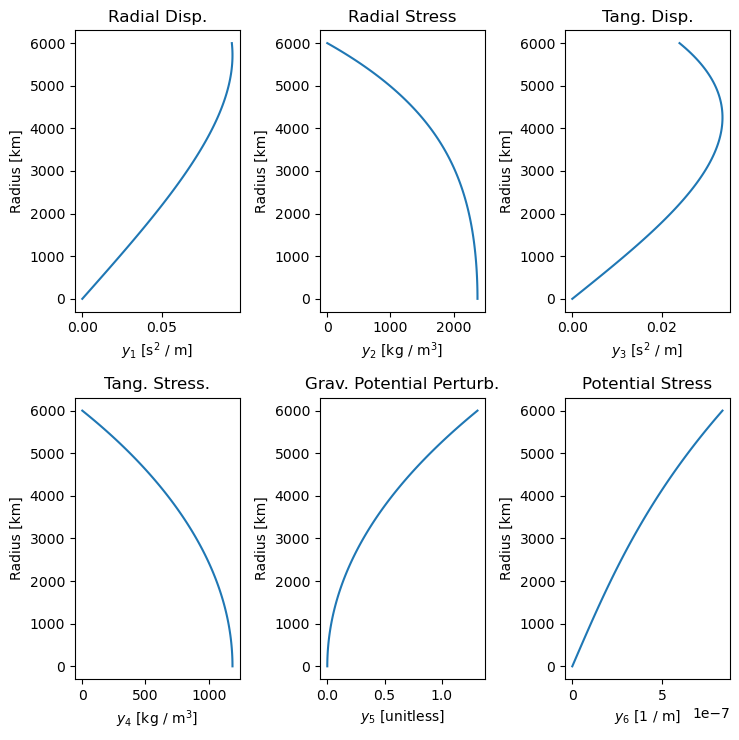

In [5]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
# frequency = 0.001
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)

density_array = 3500. * np.ones_like(radius_array)

bulk_modulus_array = 1.0e11 * np.ones_like(radius_array)

viscosity_array = 1.0e20 * np.ones_like(radius_array)

shear_array = 5.0e10 * np.ones_like(radius_array)

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (True,)
is_static_by_layer = (False,)
is_incompressible_by_layer = (False,)
indicies = (radius_array >= 0.,)
upper_radius_by_layer = (radius_array[-1],)

out = radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False,)

#_ = yplot(out[:, 0:N:2], radius_array[0:N:2])
_ = yplot(out, radius_array)


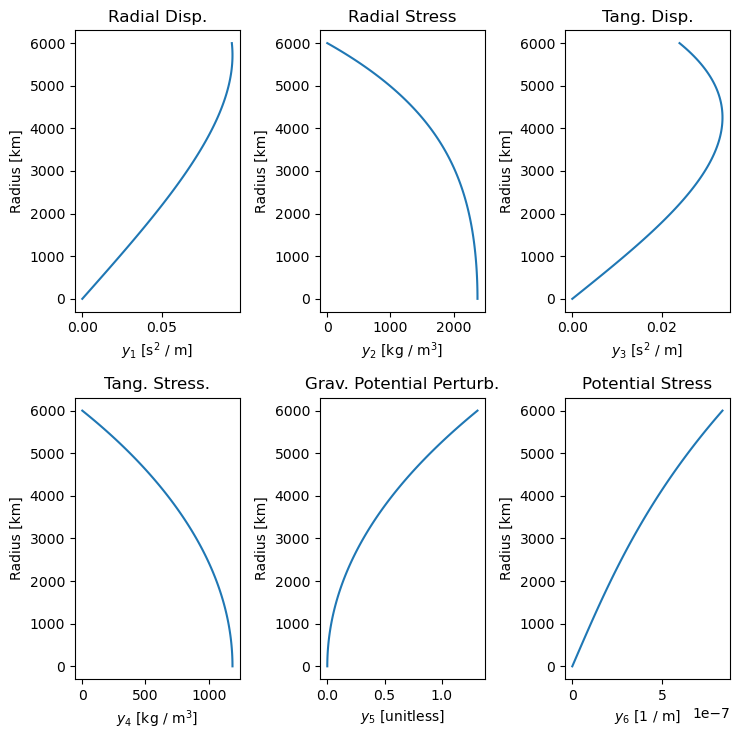

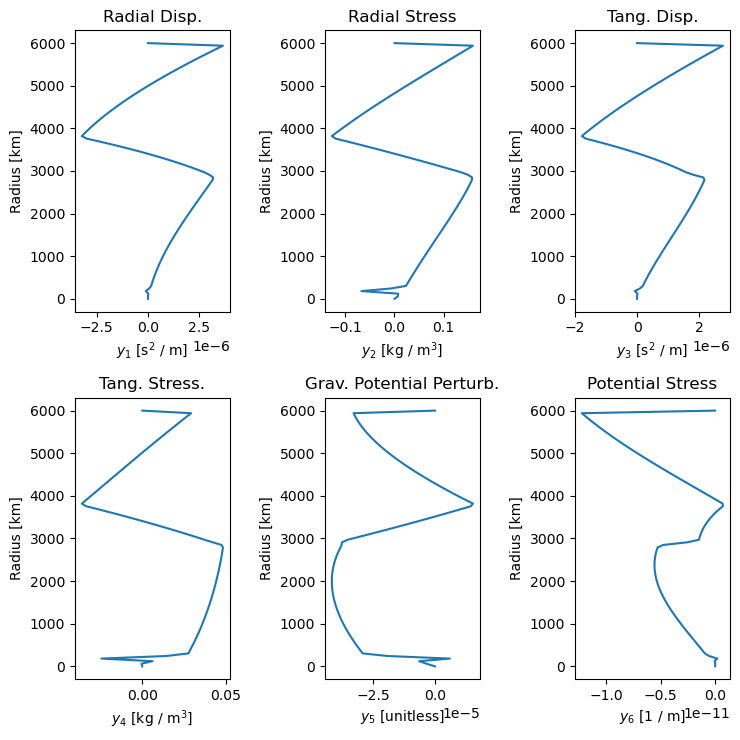

In [6]:
from TidalPy.radial_solver.numerical import radial_solver

indicies = (radius_array>=0.,)

out_old = radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot((out_old - out), radius_array)

In [7]:
# OLD (Not using NonDim):
# 312ms, 311ms, 298ms
%timeit radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)

306 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# NEW (Not using NonDim):
# 4.93ms, 4.9ms
# 2.57ms, 2.33ms
%timeit radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False)

2.38 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Liquid-Solid

In [ ]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
# frequency = 0.001
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)
CMB_radius = radius_array[-1] / 2.

density_array = 3500. * np.ones_like(radius_array)
density_array[radius_array <= CMB_radius] = 6000.

bulk_modulus_array = 1.0e11 * np.ones_like(radius_array)
bulk_modulus_array[radius_array <= CMB_radius] = 5.0e11

viscosity_array = 1.0e20 * np.ones_like(radius_array)
viscosity_array[radius_array <= CMB_radius] = 1.0e15

shear_array = 5.0e10 * np.ones_like(radius_array)
shear_array[radius_array <= CMB_radius] = 0.

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (False, True,)
is_static_by_layer = (True, False,)
is_incompressible_by_layer = (False, False,)
indicies = (radius_array <= CMB_radius, radius_array > CMB_radius)
upper_radius_by_layer = (radius_array[-1]/2., radius_array[-1],)

out = radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False,)

#_ = yplot(out[:, 0:N:2], radius_array[0:N:2])
_ = yplot(out, radius_array)


In [ ]:
from TidalPy.radial_solver.numerical import radial_solver


out_old = radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot((out_old - out), radius_array)